In [157]:
import pandas as pd
import geopandas as gpd
# run `conda install geopandas` if you don't have geopandas already installed
import matplotlib.pyplot as pl
import numpy as np
%pylab inline
import statsmodels.api as sm1
import statsmodels.formula.api as sm
from shapely.geometry import Point, MultiPolygon

Populating the interactive namespace from numpy and matplotlib


In [175]:
# this is the UN cities dataset that provides all cities over 300k people with their country name, coordinates, historic population, and future population estimates
cities_all = pd.read_csv('./WUP2018-F12-Cities_Over_300K.csv')

# get rid of spaces in the column names so it's easier to reference them
cities_all.columns = [c.replace(' ', '_') for c in cities_all.columns]
print('Headers: ',list(cities_all))
print('Count of Cities over 300K People: ',cities_all.size)

Headers:  ['Index', 'Country_Code', 'Country_or_area', 'City_Code', 'Urban_Agglomeration', 'Note', 'Latitude', 'Longitude', '1950', '1955', '1960', '1965', '1970', '1975', '1980', '1985', '1990', '1995', '2000', '2005', '2010', '2015', '2020', '2025', '2030', '2035']
Count of Cities over 300K People:  48360


In [230]:
# this csv provides a list of countries in africa. we need this so we can filter the UN cities dataset to only show african cities
countries = pd.read_csv('./african_countries.csv')
print('Headers: ',list(countries))

Headers:  ['Country', 'Population', 'Subregion']


In [177]:
# get list of distinct countries in the UN cities dataset and their respective counts of cities over 300k
countries_from_cities = cities_all.groupby(['Country_or_area']).size().reset_index(name='count')
# preview first few rows
countries_from_cities.head()

,Country_or_area,count
0,Afghanistan,4
1,Albania,1
2,Algeria,8
3,Angola,9
4,Argentina,17


In [178]:
# try merging the two tables to identify which countries are spelled differently in the two datasets
matched = pd.merge(countries, countries_from_cities, left_on = 'Country', right_on = 'Country_or_area', how='left')

# countries in the african countries dataset that are missing exact country name matches in the UN cities data
print(matched[matched.Country_or_area.isnull()])

                Country  Population        Subregion Country_or_area  count
3              DR Congo    86727573    Middle Africa             NaN    NaN
4              Tanzania    60913557   Eastern Africa             NaN    NaN
41             Botswana     2374636  Southern Africa             NaN    NaN
42              Lesotho     2292682  Southern Africa             NaN    NaN
46            Swaziland     1415414  Southern Africa             NaN    NaN
48            Mauritius     1271368   Eastern Africa             NaN    NaN
50              Comoros      850910   Eastern Africa             NaN    NaN
51           Cabo Verde      560349   Western Africa             NaN    NaN
52  Sao Tome & Principe      213379    Middle Africa             NaN    NaN
53           Seychelles       95702   Eastern Africa             NaN    NaN


In [179]:
# find the country names in UN cities dataset for the unmatched records by looking for keywords
names = []
for i, elem in enumerate(countries_from_cities.Country_or_area):
    if 'Congo' in elem or 'Tanzania' in elem or 'Botswana' in elem or 'Lesotho' in elem or 'Swaziland' in elem or 'Mauritius' in elem or 'Comoros' in elem or 'Cabo Verde' in elem or 'Sao Tome' in elem or 'Seychelles' in elem:
        names.append(countries_from_cities.Country_or_area[i])
print(names)
        

['Congo', 'Democratic Republic of the Congo', 'United Republic of Tanzania']


In [180]:
# create new df capturing filtered subset of UN data that only includes cities in africa
cities = pd.concat([
    cities_all[cities_all.Country_or_area.isin(countries.Country)],
    cities_all[cities_all.Country_or_area.isin(names)]
])

In [250]:
# sort cities data by 2020 population in descending order
cutoff = 40
cities[['Country_or_area','Urban_Agglomeration','2015','2020','2025']].sort_values(by='2020', ascending=False).head(cutoff)

,Country_or_area,Urban_Agglomeration,2015,2020,2025
684,Egypt,Al-Qahirah (Cairo),18820,20901,23074
1259,Nigeria,Lagos,12239,14368,17156
661,Democratic Republic of the Congo,Kinshasa,11598,14342,17778
18,Angola,Luanda,7023,8330,10028
1664,United Republic of Tanzania,Dar es Salaam,5116,6702,8562
1530,Sudan,Al-Khartum (Khartoum),5128,5829,6754
1501,South Africa,Johannesburg,4985,5783,6445
680,Egypt,Al-Iskandariyah (Alexandria),4789,5281,5807
642,Côte d'Ivoire,Abidjan,4533,5203,6057
696,Ethiopia,Addis Ababa,3871,4794,5957


In [256]:
# create subset of african cities in top for 2020 population
cities_largest = cities.sort_values(by='2020', ascending=False).head(cutoff)

In [254]:
# which countries have multiple cities in the top list? how many?
cities_largest.groupby(['Country_or_area']).size().reset_index(name='count').sort_values(by='count', ascending=False)

,Country_or_area,count
18,South Africa,5
15,Nigeria,5
6,Democratic Republic of the Congo,3
3,Cameroon,2
4,Congo,2
7,Egypt,2
9,Ghana,2
14,Morocco,2
0,Algeria,1
16,Senegal,1


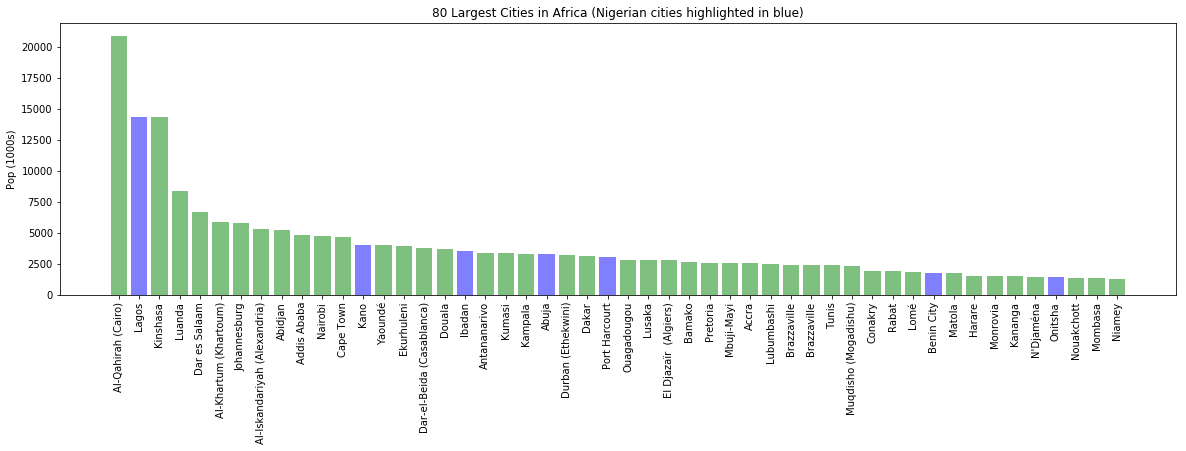

In [243]:
# vizualize largest african cities by popoulation size, highlighing cities in Nigeria
data = largest

fig, ax1 = pl.subplots()
fig.set_figheight(5)
fig.set_figwidth(20)

y_pos = np.arange(len(data))
colormat=np.where(data.Country_or_area=='Nigeria', 'b','g')
plt.bar(y_pos, data['2020'], align='center', alpha=0.5, color=colormat)
plt.xticks(y_pos, data.Urban_Agglomeration, rotation=90)
plt.ylabel('Pop (1000s)')
plt.title(str(cutoff) + ' Largest Cities in Africa (Nigerian cities highlighted in blue)')

plt.show()

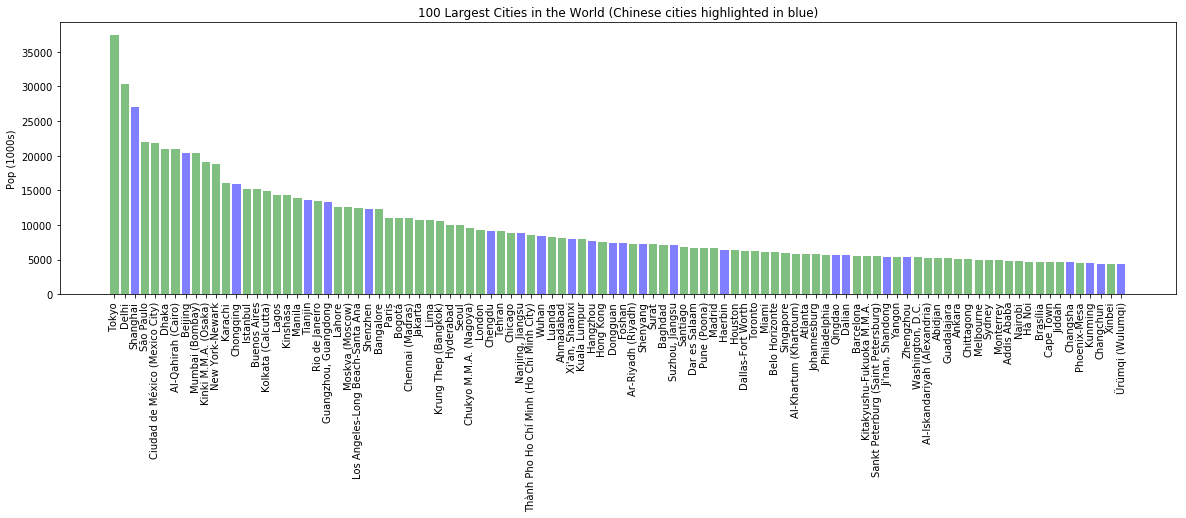

In [246]:
cutoff = 100
cities_all_largest = cities_all.sort_values(by='2020', ascending=False).head(cutoff)

data = cities_all_largest

fig, ax1 = pl.subplots()
fig.set_figheight(5)
fig.set_figwidth(20)

y_pos = np.arange(len(data))
colormat=np.where(data.Country_or_area=='China', 'b','g')
plt.bar(y_pos, data['2020'], align='center', alpha=0.5, color=colormat)
plt.xticks(y_pos, data.Urban_Agglomeration, rotation=90)
plt.ylabel('Pop (1000s)')
plt.title(str(cutoff) + ' Largest Cities in the World (Chinese cities highlighted in blue)')

plt.show()